** NOTES 
Link to csv file for Generation Forecast - Day ahead for the Netherlands:
https://transparency.entsoe.eu/generation/r2/dayAheadAggregatedGeneration/show?name=&defaultValue=true&viewType=TABLE&areaType=BZN&atch=false&datepicker-day-offset-select-dv-date-from_input=D&dateTime.dateTime=30.01.2023+00:00|CET|DAYTIMERANGE&dateTime.endDateTime=30.01.2023+00:00|CET|DAYTIMERANGE&area.values=CTY|10YNL----------L!BZN|10YNL----------L&dateTime.timezone=CET_CEST&dateTime.timezone_input=CET+(UTC+1)+/+CEST+(UTC+2)#

And here the link to day ahead generation forecasts for Germany BZN|DE-LU
https://transparency.entsoe.eu/generation/r2/dayAheadAggregatedGeneration/show?name=&defaultValue=false&viewType=TABLE&areaType=BZN&atch=false&datepicker-day-offset-select-dv-date-from_input=D&dateTime.dateTime=30.01.2024+00:00|CET|DAYTIMERANGE&dateTime.endDateTime=30.01.2024+00:00|CET|DAYTIMERANGE&area.values=CTY|10Y1001A1001A83F!BZN|10Y1001A1001A82H&dateTime.timezone=CET_CEST&dateTime.timezone_input=CET+(UTC+1)+/+CEST+(UTC+2)#

And Now Generation forecasts for solar and wind:
Solar, Wind, NL: https://transparency.entsoe.eu/generation/r2/dayAheadGenerationForecastWindAndSolar/show#
Wind only, Germany: https://transparency.entsoe.eu/generation/r2/dayAheadGenerationForecastWindAndSolar/show?name=&defaultValue=false&viewType=TABLE&areaType=BZN&atch=false&dateTime.dateTime=29.01.2024+00:00|CET|DAYTIMERANGE&dateTime.endDateTime=29.01.2024+00:00|CET|DAYTIMERANGE&area.values=CTY|10Y1001A1001A83F!BZN|10Y1001A1001A82H&productionType.values=B16&productionType.values=B18&productionType.values=B19&processType.values=A18&processType.values=A01&processType.values=A40&dateTime.timezone=CET_CEST&dateTime.timezone_input=CET+(UTC+1)+/+CEST+(UTC+2)# 



# Importing the data through .csv files

In [1]:

import datetime as dt
import pandas as pd

def parse_start_datetime(dt_str):
    start_str = dt_str.split('-')[1].strip() # we here select the end time, to be the one in the MTU_parsed
    return dt.datetime.strptime(start_str, "%d.%m.%Y %H:%M")

def import_data_csv(year):
    forecasts = pd.read_csv("data/dayahead_forecasts_nl_"+year+".csv")
    forecasts = forecasts.drop(forecasts.columns[([2,3,5,6,8,9])], axis=1)
    forecasts.rename(columns={forecasts.columns[0]: "MTU", forecasts.columns[1]: "Solar", forecasts.columns[2]: "Wind_offshore", forecasts.columns[3]: "Wind_onshore"}, inplace=True)
    forecasts[forecasts.columns[1:3]] = forecasts[forecasts.columns[1:3]].apply(pd.to_numeric, errors='coerce', axis=1)
    actuals = pd.read_csv("data/actual_nl_all_types_"+year+".csv")
    actuals = actuals.drop(actuals.columns[2:19], axis=1)
    actuals = actuals.drop(actuals.columns[3], axis=1)
    actuals.rename(columns={actuals.columns[2]: "Solar", actuals.columns[3]: "Wind_offshore",
                            actuals.columns[4]: "Wind_onshore"}, inplace=True)
    
    actuals[actuals.columns[2:5]] = actuals[actuals.columns[2:5]].apply(pd.to_numeric, errors='coerce', axis=1)
    actuals = actuals.drop(actuals.columns[0], axis=1)
    actuals['MTU'] = actuals['MTU'].str.replace("(CET/CEST)","")

    actuals['MTU_parsed'] = actuals['MTU'].apply(parse_start_datetime)
    forecasts['MTU_parsed'] = forecasts['MTU'].apply(parse_start_datetime)

    df = pd.merge(forecasts, actuals, on='MTU_parsed', how='inner', suffixes=('_forecast', '_actuals'))
    df.set_index('MTU_parsed', inplace=True)
    # replace NaN with 0 and "-" with the integer 0
    df = df.fillna(0)
    df = df.replace('-', 0)
    # convert all columns to numeric
    df = df.apply(pd.to_numeric, errors='coerce', axis=1)
    df.drop(df.columns[[0,4]], axis=1, inplace=True)

    return df #merged df for forecasts and actuals

df_2021 = import_data_csv("2021")
df_2022 = import_data_csv("2022")
df_2023 = import_data_csv("2023")
df_2024 = import_data_csv("2024")

In [2]:
# now merge
df = pd.concat([df_2021, df_2022, df_2023, df_2024])


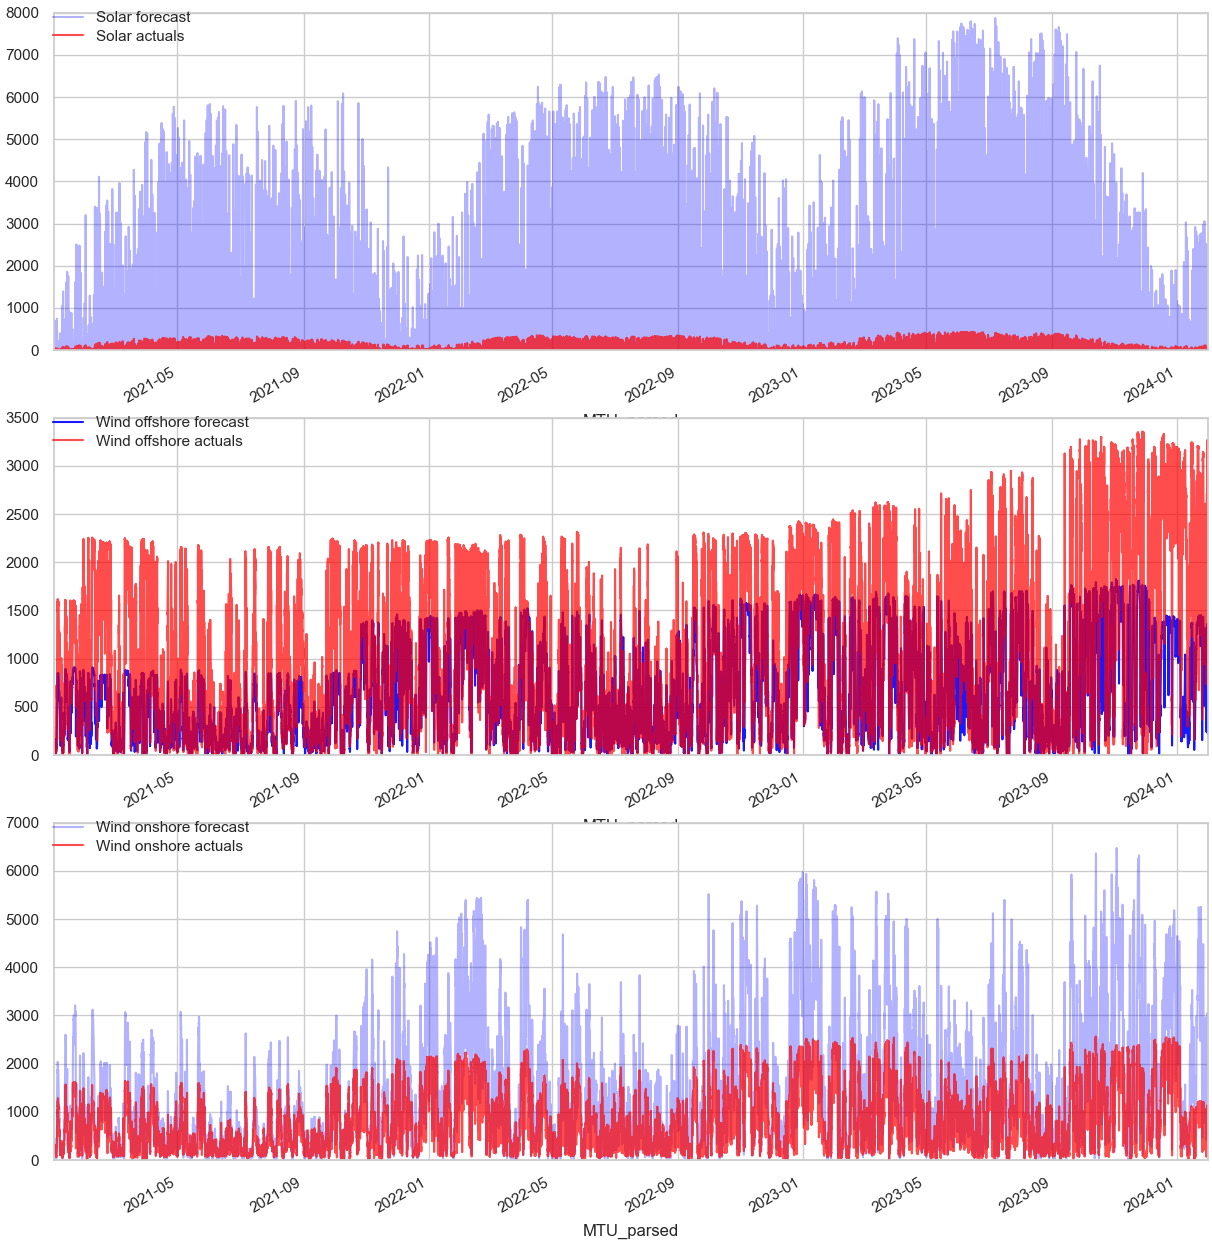

In [70]:
# plot the data
import matplotlib.pyplot as plt
import seaborn as sns
start_date = '2021-01-01'
end_date = '2024-01-31'
df_filtered = df[(df.index >= start_date) & (df.index <= end_date)]
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
df_filtered.plot(y='Solar_forecast', ax=ax[0], color='blue', label='Solar forecast', alpha=0.3)
df_filtered.plot(y='Solar_actuals', ax=ax[0], color='red', label='Solar actuals', alpha=0.7)
df_filtered.plot(y='Wind_offshore_forecast',ax=ax[1], color='blue', label='Wind offshore forecast', alpha=0.9)
df_filtered.plot(y='Wind_offshore_actuals',ax=ax[1], color='red', label='Wind offshore actuals', alpha=0.7)
df_filtered.plot(y='Wind_onshore_forecast',ax=ax[2], color='blue', label='Wind onshore forecast', alpha=0.3)
df_filtered.plot(y='Wind_onshore_actuals',ax=ax[2], color='red', label='Wind onshore actuals', alpha=0.7)
plt.show()

In [3]:
# df.to_excel("data/forecast_vs_actuals_21_22_2023_and_2024.xlsx")

In [4]:
import pandas as pd
# df = pd.read_excel("data/forecast_vs_actuals_21_22_2023_and_2024.xlsx")

In [5]:
df["Solar_Err"] = ((df["Solar_forecast"] - df["Solar_actuals"]))
df["Wind_offshore_Err"] = ((df["Wind_offshore_forecast"] - df["Wind_offshore_actuals"]))
df["Wind_onshore_Err"] = ((df["Wind_onshore_forecast"] - df["Wind_onshore_actuals"]))

In [46]:
df["Solar_Err_perc"] = ((df["Solar_Err"] / df["Solar_actuals"]) * 100)
df["Wind_offshore_Err_perc"] = ((df["Wind_offshore_Err"] / df["Wind_offshore_actuals"]) * 100)
df["Wind_onshore_Err_perc"] = ((df["Wind_onshore_Err"] / df["Wind_onshore_actuals"]) * 100)

# set inf or very big values to Nan
df["Solar_Err_perc"] = df["Solar_Err_perc"].replace([float('inf'), float('-inf')], float('nan'))
df["Wind_offshore_Err_perc"] = df["Wind_offshore_Err_perc"].replace([float('inf'), float('-inf')], float('nan'))
df["Wind_onshore_Err_perc"] = df["Wind_onshore_Err_perc"].replace([float('inf'), float('-inf')], float('nan'))


/Users/bastian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bastian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bastian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


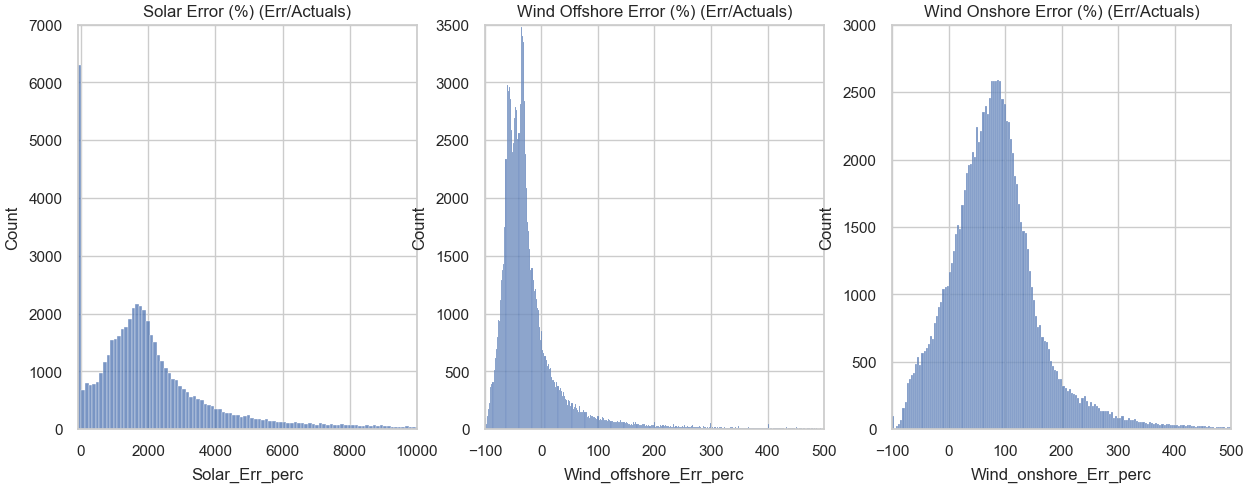

In [50]:
# plot the percentage errors
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# ses x lim to -100,100
ax[0].set_xlim(-100, 10000)
ax[1].set_xlim(-100, 500)
ax[2].set_xlim(-100, 500)
sns.histplot(df["Solar_Err_perc"], kde=False, ax=ax[0])
sns.histplot(df["Wind_offshore_Err_perc"], kde=False, ax=ax[1])
sns.histplot(df["Wind_onshore_Err_perc"], kde=False, ax=ax[2])
ax[0].set_title("Solar Error (%) (Err/Actuals)")
ax[1].set_title("Wind Offshore Error (%) (Err/Actuals)")
ax[2].set_title("Wind Onshore Error (%) (Err/Actuals)")
plt.show()


In [65]:
print(df[['Solar_Err_perc', 'Wind_offshore_Err_perc', 'Wind_onshore_Err_perc']].describe().round(2).to_latex())

\begin{tabular}{lrrr}
\toprule
 & Solar_Err_perc & Wind_offshore_Err_perc & Wind_onshore_Err_perc \\
\midrule
count & 59045.000000 & 107672.000000 & 108173.000000 \\
mean & 3466.890000 & 21.750000 & 93.780000 \\
std & 8309.330000 & 524.110000 & 198.330000 \\
min & -100.000000 & -100.000000 & -100.000000 \\
25% & 946.670000 & -54.300000 & 33.190000 \\
50% & 1800.000000 & -35.220000 & 78.550000 \\
75% & 3031.820000 & -8.730000 & 121.900000 \\
max & 314300.000000 & 66600.000000 & 9382.350000 \\
\bottomrule
\end{tabular}



In [42]:
sum(df["Solar_Err"] >=0) / len(df["Solar_Err"]) * 100

95.57175846732808

In [54]:
# display descriptive statistics for the errors
df[["Solar_Err", "Wind_offshore_Err", "Wind_onshore_Err"]].describe().round(2)
# convert to latex
# print(df[["Solar_Err", "Wind_offshore_Err", "Wind_onshore_Err"]].describe().round(2).to_latex())

Solar_Err  Wind_offshore_Err  Wind_onshore_Err
count  140304.00          140304.00         140304.00
mean      815.97            -317.37            531.80
std      1485.71             485.03            755.69
min      -129.00           -3152.00          -2326.00
25%         0.00            -592.00              0.00
50%         0.00            -108.00            218.00
75%       977.00               0.00            797.00
max      7464.00            1561.00           4821.00

/Users/bastian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bastian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bastian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


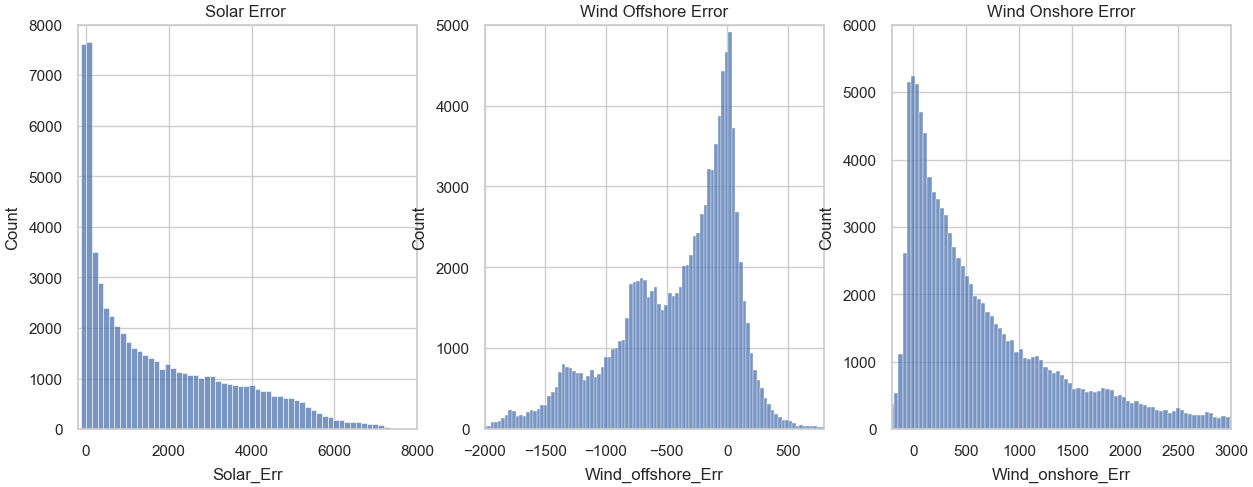

In [62]:
# plot the percentage errors
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# set x lim at 5 and 95% percentiles
ax[0].set_xlim(-200, 8000)
ax[1].set_xlim(-2000, 800)
ax[2].set_xlim(-200, 3000)
sns.histplot(df[df["Solar_Err"] != 0]["Solar_Err"], kde=False, ax=ax[0])
sns.histplot(df[df["Wind_offshore_Err"] != 0]["Wind_offshore_Err"], kde=False, ax=ax[1])
sns.histplot(df[df["Wind_onshore_Err"] != 0]["Wind_onshore_Err"], kde=False, ax=ax[2])
ax[0].set_title("Solar Error ")
ax[1].set_title("Wind Offshore Error")
ax[2].set_title("Wind Onshore Error")
plt.show()


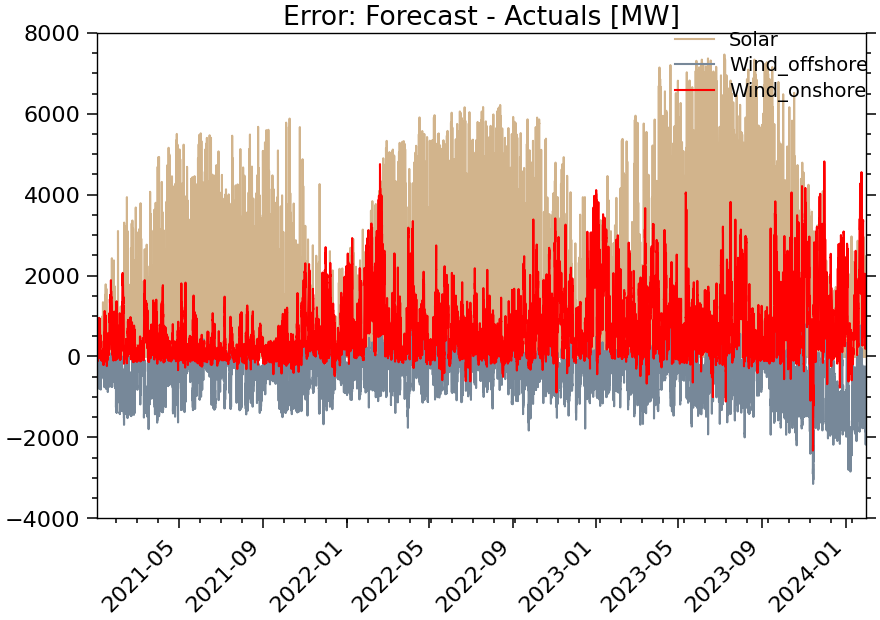

In [33]:


import matplotlib.pyplot as plt
plt.style.use('default')
plt.style.use('extensys')



# Filter the dataframe for the first month of 2024
start_date = '2021-01-01'
end_date = '2024-01-31'
df_filtered = df[(df.index >= start_date) & (df.index <= end_date)]


plt.figure(figsize=(10, 6))
# Plot the filtered data
plt.plot(df_filtered["Solar_Err"], label="Solar")
plt.plot(df_filtered["Wind_offshore_Err"], label="Wind_offshore")
plt.plot(df_filtered["Wind_onshore_Err"], label="Wind_onshore")
plt.title("Error: Forecast - Actuals [MW]")
# rotate and align the tick labels so they look better
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

/var/folders/7s/0tfvt_917hx3491lbv5l5h9w0000gn/T/ipykernel_34865/1592178256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Year'] = df_filtered.index.year
/var/folders/7s/0tfvt_917hx3491lbv5l5h9w0000gn/T/ipykernel_34865/1592178256.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Month'] = df_filtered.index.month


<Axes: xlabel='Month'>

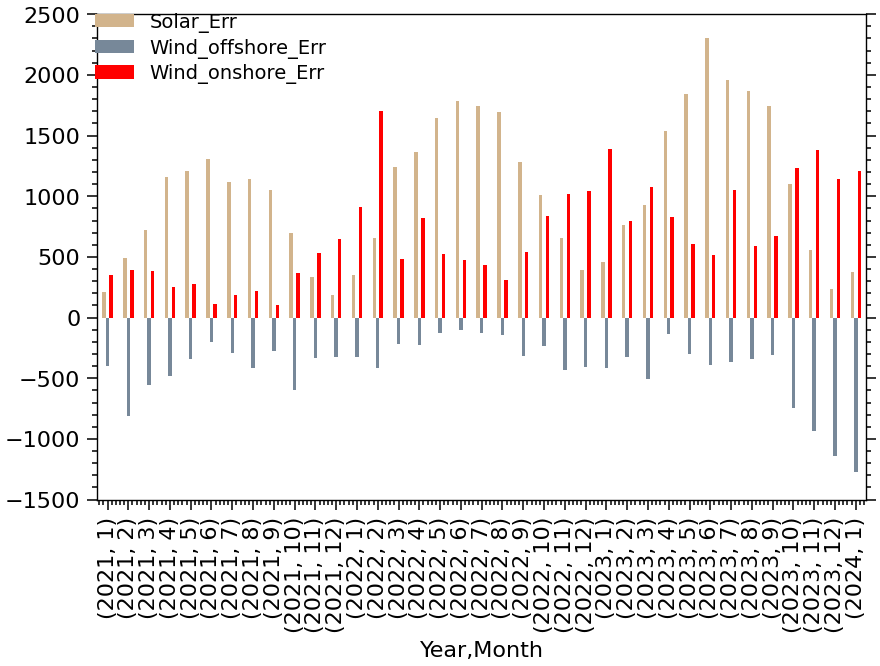

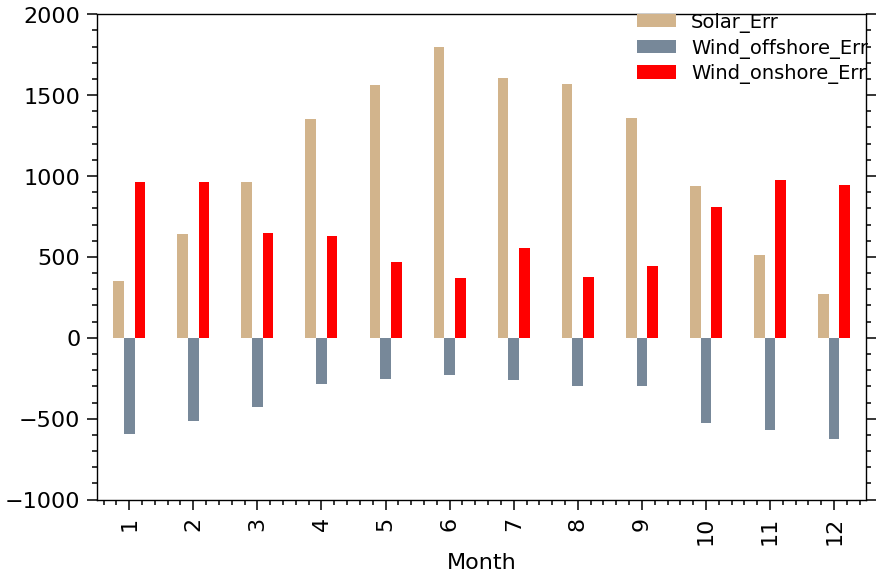

In [32]:
# group the Err by year and month
df_filtered['Year'] = df_filtered.index.year
df_filtered['Month'] = df_filtered.index.month

df_grouped = df_filtered.groupby(['Year', 'Month']).mean()
df_grouped = df_grouped[["Solar_Err", "Wind_offshore_Err", "Wind_onshore_Err"]]
df_grouped.plot(kind='bar', figsize=(10, 6))
df_grouped = df_filtered.groupby('Month').mean()
df_grouped = df_grouped[["Solar_Err", "Wind_offshore_Err", "Wind_onshore_Err"]]
df_grouped.plot(kind='bar', figsize=(10, 6))

In [20]:
print(len(df_filtered["Solar_Err"]))
print(len(df_filtered["Wind_offshore_Err"]))
print(len(df_filtered["Wind_onshore_Err"]))

37933
37933
37933


In [19]:
# build a skeleton to create a likelihood inference on error correction model parameters
import pymc as pm



WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
